#Challenge 2019 / Lesion Diagnosis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash

# Importamos las dependencias

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import *
from IPython.display import clear_output
from torchvision.transforms import *
import torchvision.models as models


In [2]:
#export
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [ ]:
!python notebook2script-Copy1.py Tesis.ipynb

### Xresnet

In [3]:
#export
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

In [4]:
#export
act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

In [5]:
#export
class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [6]:
#export
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(n_blocks)])

In [7]:
#export
def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

# Descargamos el dataset


## 2018

In [ ]:
!wget https://challenge.kitware.com/api/v1/item/5ac20fc456357d4ff856e139/download

In [ ]:
urls2018 = [
        #     'https://challenge.kitware.com/api/v1/item/5ac20fc456357d4ff856e139/download',
        # 'https://challenge.kitware.com/api/v1/item/5ac20eeb56357d4ff856e136/download',
        # 'https://challenge.kitware.com/api/v1/item/5b1c1c7256357d41064da302/download',
        'https://challenge.kitware.com/api/v1/item/5b1c200656357d41064da305/download']

In [ ]:
for idx,url in enumerate(urls2018):
  !wget $url

In [ ]:
!unzip download 

In [ ]:
!ls 

## 2019

In [ ]:
urls2019 = ['https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip',
        'https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv']

In [ ]:
for idx,url in enumerate(urls2019):
  !wget $url

In [ ]:
%time !unzip ISIC_2019_Training_Input.zip

# Ordenamos los datos


## 2019

In [26]:
tesisPath = Path('./');
# tesisPath = Path('/content/drive/My Drive/tesis/live2018');

trainImagesFolderName = './segmented_images/ISIC_2019_Training_Input'
# validImagesFolderName = 'ISIC2018_Task3_Valid_Input'
testImagesFolderName = 'ISIC2018_Task3_Test_Input'


trainImages = tesisPath/trainImagesFolderName
# validImages = tesisPath/validImagesFolderName
testImages = tesisPath/testImagesFolderName

smallTrainFolderName = Path('small-train')
smallTrainPath = tesisPath/smallTrainFolderName
smallTrainPath.mkdir(exist_ok=True)

smallValidFolderName = Path('small-valid')
smallValidPath = tesisPath/smallValidFolderName
smallValidPath.mkdir(exist_ok=True)

smallTestfolderName = Path('small-test')
smallTestPath = tesisPath/smallTestfolderName
smallTestPath.mkdir(exist_ok=True)


trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'
trainingGroundTruthFilePath = tesisPath/trainingGroundTruthFileName


trainImagesPath = tesisPath/trainImagesFolderName

testImagesPath = tesisPath/testImagesFolderName


In [21]:
df = pd.read_csv(trainingGroundTruthFilePath); print('# of images: ', len(df)); df.head()

# of images:  25331


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
dfSingleLabel = pd.DataFrame({'image':df['image'] })
labelcols = df.columns[1:len(df.columns)]
dfSingleLabel['label'] = df[list(labelcols)].idxmax(axis='columns')
dfSingleLabel.head()

,image,label
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


# Sección nueva

## Common

In [23]:
labels_for_2018_live_challenge = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']
def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image']==image_name].label)[0]
  
def get_label_for_image_path(image_path): return get_label_for_image_name(image_path.name[:-4])

# Preprocesamos las imagenes


In [24]:
def remove_small_train():
  assert smallTrainPath
  !cd $smallTrainPath && rm -rf *

In [ ]:
# remove_small_train()

In [25]:
smallTrainPath.ls(),smallTestPath.ls(),smallValidPath.ls()

([PosixPath('small-train/128x128'),
  PosixPath('small-train/180x180'),
  PosixPath('small-train/352x352'),
  PosixPath('small-train/112x112'),
  PosixPath('small-train/448x448')],
 [],
 [])

In [78]:
quantity = 400
size = 448

sizePath = str(size)+"x"+str(size)
specificSmallTrainFolderName = (smallTrainFolderName/sizePath).as_posix()

image_quantities_dict = {}
for label in labelcols:
  image_quantities_dict[label] = 0

## 2018

In [ ]:
datasetFoldersPath = [
    ('/content/ISIC2018_Task3_Test_Input', smallTestPath),
                      # ('/content/ISIC2018_Task3_Training_Input',smallTrainPath),
                      # ('/content/ISIC2018_Task3_Validation_Input',smallValidPath)
                      ]

## 2019

In [79]:
datasetFoldersPath = [
                      (trainImagesPath, smallTrainPath),
                      # (testImagesPath,smallTestPath)
                      ]

## Common

In [80]:
transform_color = False

In [81]:
trans_to_tensor = transforms.ToTensor()
trans_to_pil = transforms.ToPILImage()

In [82]:
def moveAndResizeImage(originImagePath, destinationImagePath):
  img = PIL.Image.open(originImagePath)
  targ_sz = resize_to(img, size, use_min=True)
  img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
  w, h = img.size

  if transform_color:
   img = trans_to_pil( _correct_color(trans_to_tensor(img)))

  left = (w - size)/2
  top = (h - size)/2
  right = (w + size)/2
  bottom = (h + size)/2
  img = img.crop((left, top, right, bottom))
  img.save(destinationImagePath, quality=100)

In [83]:
def createSmallerDataset():
    for datasetPath, smallDatasetPath in datasetFoldersPath[0:1]:
      print('started: ', datasetPath)
      images_paths_list = get_image_files(datasetPath)

      n_of_images = min(len(images_paths_list), len(labels_for_2018_live_challenge) * quantity)
      print(n_of_images)

      n_of_processed_images = 0

      for image_path in images_paths_list:
        image_label = get_label_for_image_name(image_path.name[:-4])
        if image_quantities_dict[image_label] >= quantity: continue
        if sum(image_quantities_dict.values()) >= quantity * len(labels_for_2018_live_challenge): break
        if image_label == 'SCC' : continue
        if image_label == 'UNK' : continue

        destinationImagePath = Path(smallDatasetPath)/(str(size)+"x"+str(size))
        destinationImagePath.mkdir(exist_ok=True, parents=True)
        destinationImagePath = destinationImagePath/image_path.name
        moveAndResizeImage(image_path,destinationImagePath)
        update_progress(n_of_processed_images/ n_of_images)
        image_quantities_dict[image_label] = image_quantities_dict[image_label] + 1
        n_of_processed_images += 1


In [84]:
createSmallerDataset()

Progress: [##################--] 89.0%


In [ ]:
for datasetPath,smallDatasetPath in datasetFoldersPath[0:1]:
  sizePath = str(size)+"x"+str(size)
  print(smallDatasetPath.name, 'quantity: ', len(get_image_files(smallDatasetPath/sizePath))  )

# Crear los data bunchs



### Estimating the Iluminants

In [ ]:
def max_rgb(image):
  # First get the maximum across the rows, then take the values and take the maximum again (this time dimension 1 will be the columns)
  return image.max(dim=1)[0].max(dim=1)[0]
  
def computeGrayWorldOnChannel(image, channel,p):
  I_cx = image[channel].sum()
  img_size = image[channel].shape.numel()
  return ( (I_cx ** p) / img_size )  ** (1/p) 
  
def shades_of_gray(img, p):
  n_channels, height, width  = img.shape
  iluminant = torch.zeros(3)
  for channel in range(n_channels):
    iluminant[channel] = computeGrayWorldOnChannel(img,channel,p)
  return iluminant

In [ ]:
def correct_iluminant(estimated_iluminant):
  gamma = (torch.ones(3) / math.sqrt(3))
  corrected_iluminant = gamma * (1 / estimated_iluminant)
  return corrected_iluminant

def correct_image(image,estimated_iluminant):
  corrected_iluminant = correct_iluminant(estimated_iluminant)
  mat_iluminant = corrected_iluminant[:,None,None].expand(image.shape)
  c = mat_iluminant * image
  return c

In [ ]:
def _correct_color(x):
  # estimated_iluminant = shades_of_gray(x,1);
  estimated_iluminant = max_rgb(x);

  c = correct_image(x,estimated_iluminant)
  return c
correct_color = TfmPixel(_correct_color)

# Data block loading API

In [12]:
def random_seed(seed_value, use_cuda):  #gleaned from multiple forum posts
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: torch.cuda.manual_seed_all(seed_value) # gpu 

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [14]:
specificSmallTrainFolderName

NameError: name 'specificSmallTrainFolderName' is not defined

In [15]:
!export CUDA_VISIBLE_DEVICES=1

In [28]:
random_seed(42,True)
tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=.3,p_affine=1)
#Descomentar para correccion de color
# tfms[0].append(correct_color())
# tfms[1].append(correct_color())

data = ImageList.from_folder(trainImagesPath)\
.split_by_rand_pct()\
.label_from_func(get_label_for_image_path)\
.transform(tfms)\
.databunch(bs=32)\
.normalize()

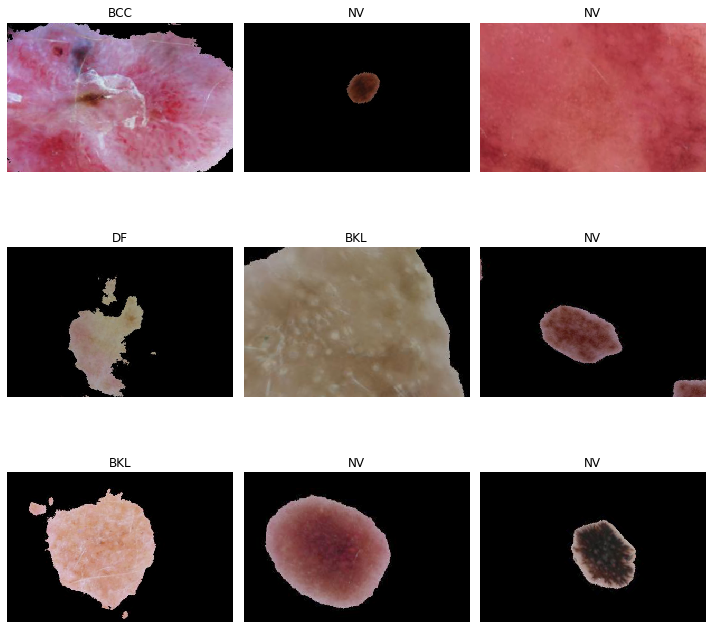

In [29]:
data.show_batch(rows=3, figsize=(10,10))

# Miremos las imagenes

Veamos cuántas imágenes de cada categoría tenemos. Recordar que se va a printear un poco menos, pues estamos tomando el 20% para validation set


In [30]:
vc = pd.value_counts(data.train_ds.y.items, sort=False)
vc.index = data.classes; vc

AK        692
BCC      2670
BKL      2065
DF        185
MEL      3579
NV      10361
SCC       510
VASC      203
dtype: int64

In [ ]:
w = vc.sum() / vc ; w = w / w.sum(); w

In [ ]:
print("Una imagen cualquiera es: "); 
data.train_ds[3][0].show()

Ejemplos de varias imagenes

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

Veamos unas transformaciones ejemplo a una misma imagen:


In [ ]:
def _plot(i,j,ax):
    x,y = data.train_ds[10]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))


In [ ]:
print(data.classes)
len(data.classes),data.c

# Entrenamos:


## Attention

In [ ]:
import types

from torchvision.models.resnet import BasicBlock

In [ ]:
def attn_forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out += self.softmaxLayer(identity) * self.alpha
        out = self.relu(out)

        return out

def add_attn_to_forward_func(a_module):
    a_module.forward = types.MethodType( attn_forward,a_module)
    
def add_attn_params(a_module):
    a_module.softmaxLayer = nn.Softmax2d();
    a_module.alpha = nn.Parameter(torch.ones(1) / 10000)
    
def change_basic_blocks(a_module):
    if not isinstance(a_module,BasicBlock): return
    add_attn_params(a_module)
    add_attn_to_forward_func(a_module)

In [ ]:
resnet50_with_attn = models.resnet50()
apply_leaf(resnet50_with_attn, change_basic_blocks)

In [ ]:
def mock_arch_init(params): 
  return resnet50_with_attn

## Empty Cache

In [2]:
learn.destroy??

Object `learn.destroy` not found.


In [ ]:
del learn
del data

In [ ]:
 torch.cuda.empty_cache()
 gc.collect()

In [ ]:
!export CUDA_VISIBLE_DEVICES=1

In [ ]:
!nvidia-smi

## Experiment training

In [31]:
xres = lambda x: xresnet50()

random_seed(7,True)
learn = cnn_learner(data,xres, 
                    metrics=[error_rate,accuracy],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats
                                  ], 
                    
                    model_dir='./',
                    pretrained=False
                    )

In [32]:
learn.fit_one_cycle(4, 
                    wd=1e-6,
                    max_lr=1e-3,
                    callbacks = [
                                 SaveModelCallback(learn=learn)
#                                 ReduceLROnPlateauCallback(learn=learn)

                                 ]
                    )

epoch,train_loss,valid_loss,error_rate,accuracy,time


RuntimeError: number of dims don't match in permute

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, wd=1e-06, max_lr=slice(1e-05,1e-04),callbacks = [
    SaveModelCallback(learn=learn),
    ReduceLROnPlateauCallback(learn=learn)
])

In [ ]:
learn.save('good')

In [ ]:
learn.load('bestmodel')

In [ ]:
model_summary(learn)

In [ ]:
m = list(learn.model.parameters())

In [ ]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    if mod.training:
        means.append(outp.data.mean())
        stds .append(outp.data.std())

In [ ]:
what_to_plot = 'std'
property_idx = 0 if what_to_plot == 'mean' else 1
layer_idx = 0

plt.plot(learn.activation_stats.stats[property_idx][0]);
plt.plot(learn.activation_stats.stats[property_idx][1]);



# learn.activation_stats.stats[property_idx][layer_idx].plot()

## Actual training

In [ ]:
!nvidia-smi

In [ ]:
# max_lr = slice(1e-3,1e-2)
max_lr = slice(1e-3,1e-2)

wd = 1e-4

In [ ]:
learn.fit_one_cycle(10,
                    callbacks = [
                                #  SaveModelCallback(learn=learn),
                                 ]
                    )

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.activation_stats.stats.shape

In [ ]:
what_to_plot = 'mean'
property_idx = 0 if what_to_plot == 'mean' else 1
layer_idx = 0

plt.plot(learn.activation_stats.stats[property_idx][3]);

# learn.activation_stats.stats[property_idx][layer_idx].plot()

In [ ]:
len(learn.activation_stats.stats[0])

In [ ]:
learn.save('resnet152_352')

In [ ]:
!ls small-train/96x96/models

In [ ]:
learn.lr_find()
learn.recorder.plot()

# doc(learn.lr_find)

In [ ]:
learn.fit_one_cycle??

In [ ]:
learn.unfreeze()

learn.fit_one_cycle(10, wd=1e-06, max_lr=slice(1e-05,1e-04),callbacks = [SaveModelCallback(learn=learn)])

In [ ]:
learn.save('resnet152_fulltrained_352')

In [ ]:
learn.save('resnet34-352x352-88Accurracy')

In [ ]:
learn.summary()

In [ ]:
learn.export()

In [ ]:
learn.load('colab-unfreeze-trained-50')

In [ ]:
learn.export('colab-unfreeze-trained.pkl')

# HeatMap

In [ ]:
learn.summary()

In [ ]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]
x.shape

In [ ]:
m = learn.model.eval();


In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g
hook_a,hook_g = hooked_backward()
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.3, extent=(0,96,96,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
show_heatmap(avg_acts), x.show()


# Results

In [ ]:
# learn.export()
learn.load('good')

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [75]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [ ]:
learn.show_results??

In [ ]:
interp.plot_top_losses(30, figsize=(12,12),heatmap=True)

In [ ]:
doc(interp.plot_top_losses)

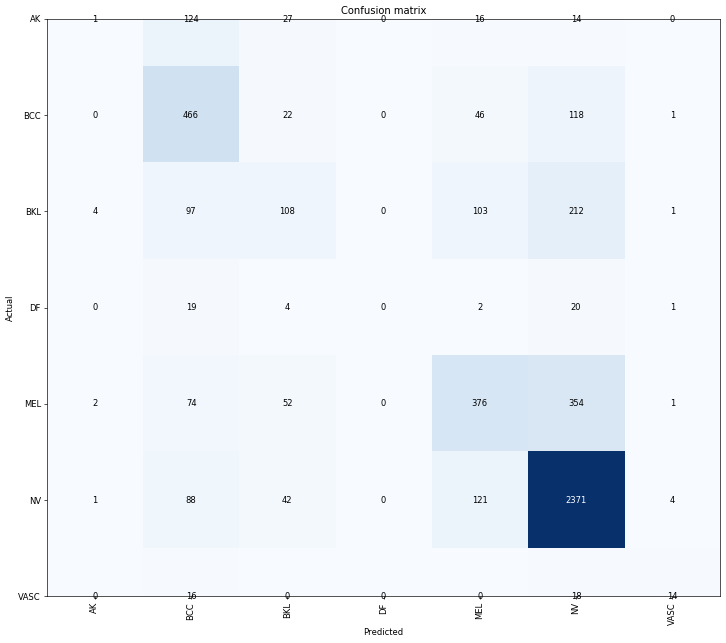

In [76]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [77]:

def get_balanced_accurracy(a_confusion_matrix):
  balanced_acc = 0
  for i in range(len(matrix[0])):
    row = matrix[i]
    correctGuesses = row[i]
    allPossibleTries = row.sum()
    classAcurracy = correctGuesses / allPossibleTries
    balanced_acc += classAcurracy
#     print(classAcurracy)
  balanced_acc /= len(matrix[0])
  return balanced_acc



matrix = interp.confusion_matrix()
"average acc: ", get_balanced_accurracy(matrix)


('average acc: ', 0.3652533679228611)

In [ ]:
matrix = interp.confusion_matrix()
"Missclassified: ", matrix.sum() - np.diag(matrix).sum(), " of ",  matrix.sum()

In [ ]:
# model_weight_path = learn.save('checkpointw',return_path=True)
# learn.export('checkpointall')
# model_weight_path

In [ ]:
interp.most_confused(min_val=2)

In [ ]:
# learn = load_learner(path=currentDatasetPath,file='muy bueno')
# learn.export()
smallTestImages

# Predicting a different batch

In [ ]:
learn.export()

In [ ]:
smallTestfolderName

In [ ]:
learn2 = load_learner(path=specificSmallTrainFolderName, file="export.pkl", 
                     test=ImageList.from_folder(smallTestfolderName),
                     )

In [ ]:
learn2.data

## Getting CSV output for our own generated validation dataset

In [ ]:
preds, y = learn2.get_preds(ds_type=DatasetType.Test); preds[0]

In [ ]:
preds, y = learn2.TTA(ds_type=DatasetType.Test, beta=0.4, scale=1.35)

In [ ]:
assert len(preds) == 1512

In [ ]:
arrOfPreds = [learn2.data.classes[pred.argmax().item()] for pred in preds];arrOfPreds[0:5]

Generamos primero el dataframe con las predicciones

In [ ]:

allCategories = learn2.data.classes
cols = ['image'] + allCategories


predictions = []
for idx, filePath in enumerate(learn2.data.test_ds.items):
  row = {}
  current_pred = preds[idx]
  max_confidence = current_pred.max().item()
  row['image'] = filePath.name.replace('.jpg','')
  for idx2, cat in enumerate(allCategories):
    row[cat] = current_pred[idx2].item()
  
  predictions.append(row)

predictionsDf = pd.DataFrame(predictions, columns=cols);
  
  

In [ ]:
len(predictionsDf)
predictionsDf = predictionsDf.rename(columns={'AK':'AKIEC'})
predictionsDf.head()

In [ ]:
# predictionsDf['UNK']=0.0; predictionsDf.head()
# predictionsDf = predictionsDf.rename(columns={'AK':'AKIEC'})

## Old

Ahora generamos el dataframe con los labels reales



In [ ]:

allCategories = learn.data.classes #+ ["UNK"]
cols = ['image'] + allCategories


trueLabels = []
for idx, filePath in enumerate(data.valid_ds.items):
  row = {}
  row['image'] = filePath.name.replace('.jpg','')
  for cat in allCategories:
    row[cat] = 0.0
    
  trueLabel = allCategories[y[idx].item()]
  row[trueLabel] = 1.0
  
  trueLabels.append(row)

trueLabelsDf = pd.DataFrame(trueLabels, columns=cols);
  
  

In [ ]:
trueLabelsDf.head()

In [ ]:
# trueLabelsDf['UNK']=0.0; trueLabelsDf.head()

Veamos alguna metrica simple

## Guardemos los csv


In [ ]:
predictions_csv_path = 'predictionsTest2018.csv'
# true_labels_csv_path = currentDatasetPath/'trueLabels.csv'



predictionsDf.to_csv(predictions_csv_path, index=False)
# trueLabelsDf.to_csv(true_labels_csv_path,index=False)



In [ ]:
# predictionsDf.sort_values('image'),trueLabelsDf.sort_values('image'),
len(learn.data.test_ds)

In [ ]:

from google.colab import files
files.download(predictions_csv_path)
# files.download(true_labels_csv_path)

In [ ]:
currentDatasetPath.ls()

# Procesando CSV

In [ ]:


def _to_labels(probabilities: pd.DataFrame) -> pd.Series:
    labels = probabilities.idxmax(axis='columns')

    # Find places where there are multiple maximum values
    max_probabilities = probabilities.max(axis='columns')
    is_max: pd.DataFrame = probabilities.eq(max_probabilities, axis='rows')
    number_of_max: pd.Series = is_max.sum(axis='columns')
    multiple_max: pd.Series = number_of_max.gt(1)
    # Set those locations as an 'undecided' label
    labels[multiple_max] = 'undecided'
    # TODO: emit a warning if any are set to 'undecided'

    return labels


def _get_frequencies(labels: pd.Series, weights: pd.Series, categories: pd.Index) -> pd.Series:
    # Directly sum the weights, grouping them by label
    # .reindex sorts this by the order in categories
    return weights.groupby(labels, sort=False).sum().reindex(categories, fill_value=0)


def _label_balanced_multiclass_accuracy(
    truth_labels: pd.Series, prediction_labels: pd.Series, weights: pd.Series, categories: pd.Index
) -> float:
    # See http://scikit-learn.org/dev/modules/model_evaluation.html#balanced-accuracy-score ; in
    # summary, 'sklearn.metrics.balanced_accuracy_score' is for binary classification only, so we
    # need to implement our own; here, we implement a simpler version of "balanced accuracy" than
    # the definitions mentioned by SciKit learn, as it's just a normalization of TP scores by true
    # class proportions
    confusion_matrix = sklearn.metrics.confusion_matrix(
        truth_labels, prediction_labels, labels=categories, sample_weight=weights
    )
    # TODO: try to convert to a DataFrame, for useful debugging labels
    # confusion_matrix = pd.DataFrame(
    #     confusion_matrix,
    #     index=LABELS.map(lambda label: f'true_{label}'),
    #     columns=LABELS.map(lambda label: f'predicted_{label}')
    # )

    tp_counts = pd.Series(confusion_matrix.diagonal(), index=categories)
#     print('digaonal', tp_counts)
    # These are equal to rows of the confusion matrix
    true_label_frequencies = _get_frequencies(truth_labels, weights, categories)

    balanced_accuracy = tp_counts.divide(true_label_frequencies).mean()
    return balanced_accuracy


def balanced_multiclass_accuracy(
    truth_probabilities: pd.DataFrame, prediction_probabilities: pd.DataFrame, weights: pd.Series
) -> float:
    truth_labels = _to_labels(truth_probabilities)
    prediction_labels = _to_labels(prediction_probabilities)
    categories = truth_probabilities.columns

    # This is easier to test
    balanced_accuracy = _label_balanced_multiclass_accuracy(
        truth_labels, prediction_labels, weights, categories
    )
    return balanced_accuracy


def binary_accuracy(cm: pd.Series) -> float:
    return (cm.at['TP'] + cm.at['TN']) / (cm.at['TP'] + cm.at['TN'] + cm.at['FP'] + cm.at['FN'])


def binary_sensitivity(cm: pd.Series) -> float:
    if cm.at['TP'] + cm.at['FN'] == 0:
        # sensitivity can't be calculated if all are negative, so make this metric a freebie
        return 1.0
    else:
        return cm.at['TP'] / (cm.at['TP'] + cm.at['FN'])


def binary_specificity(cm: pd.Series) -> float:
    if cm.at['TN'] + cm.at['FP'] == 0:
        # specificity can't be calculated if all are positive, so make this metric a freebie
        return 1.0
    else:
        return cm.at['TN'] / (cm.at['TN'] + cm.at['FP'])


def binary_jaccard(cm: pd.Series) -> float:
    if cm.at['TP'] + cm.at['FP'] + cm.at['FN'] == 0:
        # Jaccard is ill-defined if all are negative and the prediction is perfect, but we'll
        # just score that as a perfect answer
        return 1.0
    else:
        return cm.at['TP'] / (cm.at['TP'] + cm.at['FP'] + cm.at['FN'])


def binary_threshold_jaccard(cm: pd.Series, threshold: float = 0.65) -> float:
    jaccard = binary_jaccard(cm)
    return jaccard if jaccard >= threshold else 0.0


def binary_dice(cm: pd.Series) -> float:
    if cm.at['TP'] + cm.at['FP'] + cm.at['FN'] == 0:
        # Dice is ill-defined if all are negative and the prediction is perfect, but we'll
        # just score that as a perfect answer
        return 1.0
    else:
        return (2 * cm.at['TP']) / ((2 * cm.at['TP']) + cm.at['FP'] + cm.at['FN'])


def binary_ppv(cm: pd.Series) -> float:
    if cm.at['TP'] + cm.at['FP'] == 0:
        # PPV is ill-defined if all predictions are negative; we'll score it as perfect, which
        # doesn't penalize the case where all are truly negative (a good predictor), and is sane
        # for the case where some are truly positive (a limitation of this metric)
        # Note, some other implementations would score the latter case as 0:
        # https://github.com/dice-group/gerbil/wiki/Precision,-Recall-and-F1-measure
        return 1.0
    else:
        return cm.at['TP'] / (cm.at['TP'] + cm.at['FP'])


def binary_npv(cm: pd.Series) -> float:
    if cm.at['TN'] + cm.at['FN'] == 0:
        # NPV is ill-defined if all predictions are positive; we'll score it as perfect, which
        # doesn't penalize the case where all are truly positive (a good predictor), and is sane
        # for the case where some are truly negative (a limitation of this metric)
        # Note, some other implementations would score the latter case as 0:
        # https://github.com/dice-group/gerbil/wiki/Precision,-Recall-and-F1-measure
        return 1.0
    else:
        return cm.at['TN'] / (cm.at['TN'] + cm.at['FN'])


def auc(
    truth_probabilities: pd.Series, prediction_probabilities: pd.Series, weights: pd.Series
) -> float:
    
    auc = sklearn.metrics.roc_auc_score(
        truth_probabilities, prediction_probabilities, sample_weight=weights
    )
    return auc


def auc_above_sensitivity(
    truth_probabilities: pd.Series,
    prediction_probabilities: pd.Series,
    weights: pd.Series,
    sensitivity_threshold: float,
) -> float:
    if not (0 < sensitivity_threshold <= 1.0):
        raise Exception(f'Out of bounds sensitivity_threshold: {sensitivity_threshold}.')

    # Get the ROC curve points
    # TODO: We must have both some true and false instances in truthProbabilities
    fp_rates, tp_rates, thresholds = sklearn.metrics.roc_curve(
        truth_probabilities,
        prediction_probabilities,
        sample_weight=weights,
        drop_intermediate=False,
    )

    # Calling sklearn.metrics.roc_auc_score with max_fpr always applies the McClish correction,
    # which is a transform to normalize partial AUC values into the range [0.5, 1] (for a given FPR
    # interval): http://www.ncbi.nlm.nih.gov/pubmed/2668680
    # McClish-normalized partial AUC values may be a helpful metric to evaluate on their own,
    # but they are incompatible with the overall AUC, and SciKit learn (unlike R) does not
    # provide a flag to return the raw partial AUC, so just compute the desired metric directly

    # Search for the index along the curve where sensitivity_threshold (i.e. tp_rate threshold)
    # occurs
    # Since tp_rates is ordered, searchsorted provides better performance than np.argmax
    # Use side='left' to include any following points with exactly the target value
    threshold_index = tp_rates.searchsorted(sensitivity_threshold, side='left')

    # Take only the segment >= the value at threshold_index
    tp_rates_segment = tp_rates[threshold_index:]
    fp_rates_segment = fp_rates[threshold_index:]

    # Create an additional ROC point at exactly the threshold value
    tp_rate_threshold = sensitivity_threshold
    # It will be the case that fp_rate_threshold <= tp_rates[threshold_index]
    # Since tp_rates may have repeated values (which is disallowed by np.interp), use a 2-value
    # segment directly around the threshold value
    # If fp_rate_threshold < tp_rates[threshold_index], the 2-value segment needs to start from the
    # location at threshold_index-1, so that it straddles fp_rate_threshold
    # Even if fp_rate_threshold == tp_rates[threshold_index], a 2-value segment starting before
    # threshold_index is guaranteed to have no duplicates, as threshold_index is the left
    # side of any series of duplicates (since it was found with searchsorted(..., side='left'))
    fp_rate_threshold = np.interp(
        tp_rate_threshold,
        tp_rates[threshold_index - 1 : threshold_index + 1],
        fp_rates[threshold_index - 1 : threshold_index + 1],
    )

    # Prepend the point to the segment
    tp_rates_segment = np.insert(tp_rates_segment, 0, tp_rate_threshold)
    fp_rates_segment = np.insert(fp_rates_segment, 0, fp_rate_threshold)

    partial_auc = sklearn.metrics.auc(fp_rates_segment, tp_rates_segment)
    return partial_auc


def average_precision(
    truth_probabilities: pd.Series, prediction_probabilities: pd.Series, weights: pd.Series
) -> float:
    with warnings.catch_warnings():
        # sklearn.metrics.average_precision_score sometimes causes warnings internally, but they
        # appear to be harmless
        warnings.filterwarnings(
            'ignore', category=RuntimeWarning, message=r'^invalid value encountered in true_divide$'
        )
        ap = sklearn.metrics.average_precision_score(
            truth_probabilities, prediction_probabilities, sample_weight=weights
        )
    return ap


def roc(
    truth_probabilities: pd.Series, prediction_probabilities: pd.Series, weights: pd.Series
) -> pd.DataFrame:
    fprs, tprs, thresholds = sklearn.metrics.roc_curve(
        truth_probabilities, prediction_probabilities, sample_weight=weights
    )

    roc = pd.DataFrame({'fpr': fprs, 'tpr': tprs}, index=thresholds, columns=['fpr', 'tpr'])
    return roc


In [ ]:
from typing import Optional, Tuple, Union
import numpy as np 
def create_binary_confusion_matrix(
    truth_binary_values: np.ndarray,
    prediction_binary_values: np.ndarray,
    weights: Optional[np.ndarray] = None,
    name: Optional[Union[str, Tuple[str, ...]]] = None,
) -> pd.Series:
    # This implementation is:
    # ~30x faster than sklearn.metrics.confusion_matrix
    # ~25x faster than sklearn.metrics.confusion_matrix(labels=[False, True])
    # ~6x faster than pandas.crosstab
    truth_binary_values = truth_binary_values.ravel()
    prediction_binary_values = prediction_binary_values.ravel()
    if weights is not None:
        weights = weights.ravel()

    truth_binary_negative_values = 1 - truth_binary_values
    test_binary_negative_values = 1 - prediction_binary_values

    true_positives = np.logical_and(truth_binary_values, prediction_binary_values)
    true_negatives = np.logical_and(truth_binary_negative_values, test_binary_negative_values)
    false_positives = np.logical_and(truth_binary_negative_values, prediction_binary_values)
    false_negatives = np.logical_and(truth_binary_values, test_binary_negative_values)

    if weights is not None:
        true_positives = true_positives * weights
        true_negatives = true_negatives * weights
        false_positives = false_positives * weights
        false_negatives = false_negatives * weights

    true_positive = np.sum(true_positives)
    true_negative = np.sum(true_negatives)
    false_positive = np.sum(false_positives)
    false_negative = np.sum(false_negatives)

    # Storing the matrix as a Series instead of a DataFrame makes it easier to reference elements
    # and aggregate multiple matrices
    cm = pd.Series(
        {'TP': true_positive, 'TN': true_negative, 'FP': false_positive, 'FN': false_negative},
        name=name,
    )

    return cm


def normalize_confusion_matrix(cm: pd.Series) -> pd.Series:
    return cm / cm.sum()


In [ ]:
from dataclasses import dataclass
from typing import Dict, Union


class ScoreException(Exception):
    pass


SeriesDict = Dict[str, float]
DataFrameDict = Dict[str, SeriesDict]
ScoreDict = Dict[str, Union[float, SeriesDict, DataFrameDict, Dict[str, DataFrameDict]]]


@dataclass
class Score:
    overall: float
    validation: float

    def to_string(self) -> str:
        output = f'Overall: {self.overall}\n'
        output += f'Validation: {self.validation}'
        return output

    def to_dict(self) -> ScoreDict:
        return {'overall': self.overall, 'validation': self.validation}


In [ ]:
from typing import TextIO, Tuple

import numpy as np
import pandas as pd



def parse_truth_csv(csv_file_stream: TextIO) -> Tuple[pd.DataFrame, pd.DataFrame]:
    table = pd.read_csv(csv_file_stream, header=0)

    table.set_index('image', drop=True, inplace=True, verify_integrity=False)

    # Support legacy truth files
    if 'score_weight' not in table.columns:
        table['score_weight'] = 1.0
    if 'validation_weight' not in table.columns:
        table['validation_weight'] = 1.0
    if 'ISIC_0035068' in table.index:
        # TODO: Move this to ground truth
        table.loc['ISIC_0035068', ['score_weight', 'validation_weight']] = 0.0

    probabilities = table.drop(columns=['score_weight', 'validation_weight'])
    weights = table[['score_weight', 'validation_weight']]

    return probabilities, weights


def parse_csv(csv_file_stream: TextIO, categories: pd.Index) -> pd.DataFrame:
    try:
        if csv_file_stream.read(2000).count('\n') < 2:
            # Heuristic: if there aren't 2 newlines in the first 2000 characters, it's probably
            # invalid, and we don't want to hang or crash the parser
            raise ScoreException('No newlines detected in CSV.')
        csv_file_stream.seek(0)

        try:
            probabilities = pd.read_csv(csv_file_stream, header=0, index_col=False)
        except (pd.errors.ParserError, pd.errors.EmptyDataError) as e:
            # TODO: Test something that generates a ParserError
            raise ScoreException(f'Could not parse CSV: "{str(e)}".')
        except IndexError:
            raise ScoreException('Could not parse CSV: inconsistent number of header columns.')
    except UnicodeDecodeError:
        raise ScoreException('Could not parse CSV: could not decode file as UTF-8.')

    if 'image' not in probabilities.columns:
        raise ScoreException('Missing column in CSV: "image".')

    # Pandas represents strings as 'O' (object)
    if probabilities['image'].dtype != np.dtype('O'):
        # Coercing to 'U' (unicode) ensures that even NaN values are converted;
        # however, the resulting type is still 'O'
        probabilities['image'] = probabilities['image'].astype(np.dtype('U'))

#     probabilities['image'] = probabilities['image'].str.replace(r'\.jpg$', '', case=False)

    if not probabilities['image'].is_unique:
        duplicate_images = probabilities['image'][probabilities['image'].duplicated()].unique()
        raise ScoreException(f'Duplicate image rows detected in CSV: {duplicate_images.tolist()}.')

    # The duplicate check is the same as performed by 'verify_integrity'
    probabilities.set_index('image', drop=True, inplace=True, verify_integrity=False)

    missing_columns = categories.difference(probabilities.columns)
    if not missing_columns.empty:
        raise ScoreException(f'Missing columns in CSV: {missing_columns.tolist()}.')

    extra_columns = probabilities.columns.difference(categories)
    if not extra_columns.empty:
        raise ScoreException(f'Extra columns in CSV: {extra_columns.tolist()}.')

    # sort by the order in categories
    probabilities = probabilities.reindex(categories, axis='columns')

    missing_rows = probabilities[probabilities.isnull().any(axis='columns')].index
    if not missing_rows.empty:
        raise ScoreException(f'Missing value(s) in CSV for images: {missing_rows.tolist()}.')

    non_float_columns = probabilities.dtypes[
        probabilities.dtypes.apply(lambda x: x != np.float64)
    ].index
    if not non_float_columns.empty:
        raise ScoreException(
            f'CSV contains non-floating-point value(s) in columns: {non_float_columns.tolist()}.'
        )
    # TODO: identify specific failed rows

    out_of_range_rows = probabilities[
        probabilities.applymap(lambda x: x < 0.0 or x > 1.0).any(axis='columns')
    ].index
    if not out_of_range_rows.empty:
        raise ScoreException(
            f'Values in CSV are outside the interval [0.0, 1.0] for images: '
            f'{out_of_range_rows.tolist()}.'
        )

    # TODO: fail on extra columns in data rows

    return probabilities


def validate_rows(
    truth_probabilities: pd.DataFrame, prediction_probabilities: pd.DataFrame
) -> None:
    """
    Ensure prediction rows correspond to truth rows.

    Fail when predictionProbabilities is missing rows or has extra rows compared to
    truthProbabilities.
    """
#     print(prediction_probabilities.index)
#     print(truth_probabilities.index) 

#     return
    missing_images = truth_probabilities.index.difference(prediction_probabilities.index)
    if not missing_images.empty:
        raise ScoreException(f'Missing images in CSV: {missing_images.tolist()}.')

        
    extra_images = prediction_probabilities.index.difference(truth_probabilities.index)
    if not extra_images.empty:
        raise ScoreException(f'Extra images in CSV: {len(extra_images.tolist())}.')


def sort_rows(probabilities: pd.DataFrame) -> None:
    """Sort rows by labels, in-place."""
    probabilities.sort_index(axis='rows', inplace=True)


In [ ]:
from dataclasses import dataclass
import pathlib

import pandas as pd


@dataclass(init=False)
class ClassificationScore(Score):
    per_category: pd.DataFrame
    macro_average: pd.Series
    rocs: Dict[str, pd.DataFrame]
    aggregate: pd.Series

    def __init__(
        self,
        truth_probabilities: pd.DataFrame,
        prediction_probabilities: pd.DataFrame,
        truth_weights: pd.DataFrame,
    ) -> None:
        categories = truth_probabilities.columns

        self.per_category = pd.DataFrame(
            [
                self._category_score(
                    truth_probabilities[category],
                    prediction_probabilities[category],
                    truth_weights,
                    category,
                )
                for category in categories
            ]
        )
        self.macro_average = self.per_category.mean(axis='index').rename(
            'macro_average', inplace=True
        )
        self.rocs = {
            category: roc(
                truth_probabilities[category],
                prediction_probabilities[category],
                truth_weights.score_weight,
            )
            for category in categories
        }
        # Multi-category aggregate metrics
        self.aggregate = pd.Series(
            {
                'balanced_accuracy': balanced_multiclass_accuracy(
                    truth_probabilities, prediction_probabilities, truth_weights.score_weight
                )
            },
            index=['balanced_accuracy'],
            name='aggregate',
        )

        self.overall = self.aggregate.at['balanced_accuracy']
        self.validation = balanced_multiclass_accuracy(
            truth_probabilities, prediction_probabilities, truth_weights.validation_weight
        )

    @staticmethod
    def _category_score(
        truth_category_probabilities: pd.Series,
        prediction_category_probabilities: pd.Series,
        truth_weights: pd.DataFrame,
        category: str,
    ) -> pd.Series:
        truth_binary_values: pd.Series = truth_category_probabilities.gt(0.5)
        prediction_binary_values: pd.Series = prediction_category_probabilities.gt(0.5)

        category_cm = create_binary_confusion_matrix(
            truth_binary_values=truth_binary_values.to_numpy(),
            prediction_binary_values=prediction_binary_values.to_numpy(),
            weights=truth_weights.score_weight.to_numpy(),
            name=category,
        )

        return pd.Series(
            {
                'accuracy': binary_accuracy(category_cm),
                'sensitivity': binary_sensitivity(category_cm),
                'specificity': binary_specificity(category_cm),
                'dice': binary_dice(category_cm),
                'ppv': binary_ppv(category_cm),
                'npv': binary_npv(category_cm),
                'auc': auc(
                    truth_category_probabilities,
                    prediction_category_probabilities,
                    truth_weights.score_weight,
                ),
                'auc_sens_80': auc_above_sensitivity(
                    truth_category_probabilities,
                    prediction_category_probabilities,
                    truth_weights.score_weight,
                    0.80,
                ),
                'ap': average_precision(
                    truth_category_probabilities,
                    prediction_category_probabilities,
                    truth_weights.score_weight,
                ),
            },
            index=[
                'accuracy',
                'sensitivity',
                'specificity',
                'dice',
                'ppv',
                'npv',
                'auc',
                'auc_sens_80',
                'ap',
            ],
            name=category,
        )

    def to_string(self) -> str:
        output = super().to_string()
        output += '\n\nPer-category metrics:\n'
        output += self.per_category.to_string()
        output += '\n\nMacro averaged metrics:\n'
        output += self.macro_average.to_string()
        output += '\n\nAggregate metrics:\n'
        output += self.aggregate.to_string()
        return output

    def to_dict(self, rocs: bool = True) -> ScoreDict:
        output = super().to_dict()
        output.update(
            {
                'per_category': cast(DataFrameDict, self.per_category.to_dict()),
                'macro_average': cast(SeriesDict, self.macro_average.to_dict()),
                'aggregate': cast(SeriesDict, self.aggregate.to_dict()),
            }
        )
        if rocs:
            output['rocs'] = {
                # TODO: float keys cannot serialize to JSON
                category: cast(DataFrameDict, roc.to_dict(orient='index'))
                for category, roc in self.rocs.items()
            }
        return output

    @classmethod
    def from_stream(
        cls, truth_file_stream: TextIO, prediction_file_stream: TextIO
    ):
        truth_probabilities, truth_weights = parse_truth_csv(truth_file_stream)
        categories = truth_probabilities.columns
        prediction_probabilities = parse_csv(prediction_file_stream, categories)

        validate_rows(truth_probabilities, prediction_probabilities)

        sort_rows(truth_probabilities)
        sort_rows(prediction_probabilities)

        score = cls(truth_probabilities, prediction_probabilities, truth_weights)
        return score

    @classmethod
    def from_file(
        cls, truth_file: pathlib.Path, prediction_file: pathlib.Path
    ):
        with truth_file.open('r') as truth_file_stream, prediction_file.open(
            'r'
        ) as prediction_file_stream:
            return cls.from_stream(
                cast(TextIO, truth_file_stream), cast(TextIO, prediction_file_stream)
            )


In [ ]:
import sklearn.metrics
from typing import cast

score = ClassificationScore.from_file(true_labels_csv_path, predictions_csv_path)
print(score.to_string())
